# What Should I Serve?

A Study of Restaurants in New Orleans Neighborhoods

# Introduction

Imagine for a moment that you are an restaurantuer looking for new opportunties in the city of New Orleans, Louisiana. YOu know that you have to find some way to stand out in the crowd. How can you find that 'x factor' to make your new restaurant different from all the others?

Data Science, of course! You decide that that what you need to do is get a deeper look at the restaurants currently serving the diverse and liveley neighborhoods in New Orleans. Each area of the city is home to restaurants serving diffrent menus to different clientle. In order to stand out from the crowd, you need to know what each neighborhood contains, and what each neighborhood lacks. Your plan is to find an area the Big Easy that isn't too crowded, but still has thriving businesses, and then to open up a new eatery that is serving something unlike all the others.

## Key Questions:

1.How many restaraunts are in each of the neighborhoods in New Orleans?

2.What type of food do those restraunts serve?

3.Where is there room in the market for something new?

4.What would be a unique food to serve in that neighborhood?

## About the Data
Based on the questions we are trying to answer, we need to collect data on a few different topics. First, we need to know more about the neighborhoods of New Orleans. Luckily, Wikipedia has a very helpful table of all the neighborhoods and thier geographic coordinates that we can use.

Next, we need to be able to identify the number and type of restraunts in a given neighborhood. We will use the Foursquare API to help us find and identify this information. This API will allow us to search for businesses and venues around a given geogrpahic point (like the neighborhood information from Wikipedia) and find out how many and what types of businesses are in that area. We will clean that up and group it to make an easier to follow listing of business types, then remove anything that isn't a restaurant for final analysis.

Finally, we will combine this information and perform analysis and visualization techniques using pandas, numpy, folium and other packages to decide how densely packed a neighborhood is with restaurants as well as to idenify the types of restaurants that are located in each neighborhood. We will use k-means clustering to examine the commonality of types of restaurants and provide raw counts of businesses for consideration.

In the end, we should be able to develop a simple search and retrieve function that allows you to input a neighborhood name, and get back an interactive map with the information you are looking for.

## Step Zero: Set-up

Before we start importing data, we need to intialize the notebook with all the libraries we are going to need.

In [1]:
 !conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
!pip install bs4

In [3]:
#!pip install folium
!conda install -c conda-forge folium=0.5.0 --yes  # map rendering library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be DOWNGRADED:

  folium                                        0.10.0-py_1 --> 0.5.0-py_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy # uncomment this line if you need to isntall geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans



import urllib.request, urllib.parse, urllib.error # library to handle url parsing for webscraping

#!pip install beautifulsoup4 # uncomment this line if you need to install beautifulsoup
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


In [5]:
!conda install -c conda-forge folium=0.10.0 --yes
import folium # map rendering library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.10.0


The following packages will be UPDATED:

  folium                                         0.5.0-py_0 --> 0.10.0-py_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


## Step One: Neighborhoods

The first thing we need to do is parse the Wikipedia article for the coordinates of the neighborhoods. We can do that using BeautifulSoup and urllib.

We will start by setting an empty list for data storage, and then pulling down a local copy of the article.

In [9]:
data = [] # empty list for storing information

# Request a local copy of the Article

url = 'https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans'
req = urllib.request.urlopen(url)
article = req.read().decode()

with open('NOLA_Neighborhoods.html', 'w') as fo:
    fo.write(article)

Now that we have the article, we can 'soupify' the HTML into something we can actuall work with. WE will then look for the table with the headers we want (Neighborhood, Latitude, and Longitude).

In [11]:
# Load article, turn into soup and get the <table>s.
article = open('NOLA_Neighborhoods.html').read()
soup = BeautifulSoup(article, 'html.parser')
tables = soup.find_all('table', class_='sortable')

# Search through the tables for the one with the headings we want.
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:3] == ['Neighborhood', 'Longitude', 'Latitude']:
        break

Great, we found the table. Now we need to store the contents of each line in a list of dictionaries so we can review it.



In [12]:
with open('Toronto_Postal_codes.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        neigh, lng, lat = [td.text.strip() for td in tds[:3]]
        
        data.append({'Neighborhood':neigh,'Latitude':lat,'Longitude':lng})

We can now go ahead and make a pandas dataframe of this information, as that will be easier to read and work with moving forward.

In [13]:
nola_neigh = pd.DataFrame(data)
nola_neigh.head()

,Neighborhood,Latitude,Longitude
0,U.S. NAVAL BASE,29.94608469,-90.02609253
1,ALGIERS POINT,29.95246187,-90.0516057
2,WHITNEY,29.94720026,-90.04235744
3,AUDUBON,29.93299437,-90.12145042
4,OLD AURORA,29.92444011,-90


Looking at the dataframe, there is something we might want to go ahead and correct before moving on. See how the names of the neighborhoods are in ALL CAPS? That won't look great in our visualization, so let's take care of it now.

In [14]:
nola_neigh['Neighborhood'] = nola_neigh['Neighborhood'].str.title()
nola_neigh.head()

,Neighborhood,Latitude,Longitude
0,U.S. Naval Base,29.94608469,-90.02609253
1,Algiers Point,29.95246187,-90.0516057
2,Whitney,29.94720026,-90.04235744
3,Audubon,29.93299437,-90.12145042
4,Old Aurora,29.92444011,-90


Get the Latitude and Longitude of New Orleans

We can easily do this with the Geopy library. We will need a user agent, which we are calling 'budin'.

In [47]:
address = 'New Orleans, Louisiana'

geolocator = Nominatim(user_agent="budin")
location = geolocator.geocode(address)
nola_lat = location.latitude
nola_lng = location.longitude
print('The geograpical coordinates of New Orleans are {}, {}.'.format(nola_lat, nola_lng))

The geograpical coordinates of New Orleans are 29.9499323, -90.0701156.


Build a map of New Orleans and overlay the Neighbohoods

Now that we have all this data, we can make a map of the city and look at the neighborhoods. We will use the folium library for that.

In [16]:
# create map of New Orleans using latitude and longitude values
map_nola = folium.Map(location=[nola_lat, nola_lng], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(nola_neigh['Latitude'], nola_neigh['Longitude'], nola_neigh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
             [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nola)   
    
map_nola

## Step Two: Restaurants


Now that we can locate and identify all of the neighborhoods in New Orleans, it is time to begin looking for all the restaraunts in those neighborhoods. This is going to take some integration with the FourSquare API.



In [17]:
CLIENT_ID = 'FZW44NEI4Y3M2WZWMCRSEXZ4RNX3HEDORJJKVLLJLI0XZLJH' # your Foursquare ID
CLIENT_SECRET = 'S3020QF2HZKBLMPRTPPNP3I44SJZGW02GF5XBYMA5ZFYGLN4 ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FZW44NEI4Y3M2WZWMCRSEXZ4RNX3HEDORJJKVLLJLI0XZLJH
CLIENT_SECRET:S3020QF2HZKBLMPRTPPNP3I44SJZGW02GF5XBYMA5ZFYGLN4 


Let's start by examining one neighborhood.
First, we need the coordinates of the neighborhood.

In [18]:
neighborhood_latitude = nola_neigh.loc[1 , 'Latitude'] # neighborhood latitude value
neighborhood_longitude = nola_neigh.loc[1 , 'Longitude'] # neighborhood longitude value

neighborhood_name = nola_neigh.loc[1 , 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Algiers Point are 29.95246187, -90.0516057.


With this in hand, we can look at the top 100 venues within 1 kilometer (1000 meters) of the French Quarter. We will save that information in results.

In [19]:
radius = 1000
LIMIT = 100

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

Based on our understanding of the FourSquare API, we want only the information in the items key. We also know we need the venue category types. We can address those needs now.

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tout de Suite Café,Café,29.952121,-90.051090
1,The Crown & Anchor,Bar,29.951416,-90.054220
2,Old Point Bar,Bar,29.954940,-90.050226
3,Congregation Coffee Roasters,Coffee Shop,29.951918,-90.053395
4,Levee @ Algiers Point,Scenic Lookout,29.951760,-90.048747


Exactly how many venues did we find in the French Quarter?

In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


25 venues were returned by Foursquare.


Okay, we maxed it out. However, we aren't done here. As you can see, we have venues that don't fit out target data set. Let's work on filtering that down.

Luckily, the FourSquare API has a filter feature and we can pick a Venue Category to filter by. Let's use Food, which has an id of 4d4b7105d754a06374d81259vvvvvvvvvvvvvvvvvv

In [50]:
radius = 1000
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tout de Suite Café,Café,29.952121,-90.051090
1,Tavolino Pizza & Lounge,Pizza Place,29.952053,-90.054597
2,John's Seafood,Seafood Restaurant,29.947295,-90.052572
3,The Appetite Repair Shop,New American Restaurant,29.952139,-90.049024
4,Sortez Cafe,Food,29.952169,-90.054558


That looks much better. Let's see how many Food venues we found.



In [51]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


9 venues were returned by Foursquare.


We may need to update the limit but we will see. It could be that you don't want to be in a neighborhood with that many restaurants competing for customers!

Expand the search to all Neighborhoods.
Now, we need to run the search through every neighborhood in New Orleans. Let's do that by building a function.

In [25]:
def getNearbyVenues(names, latitudes, longitudes, catId, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            catId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

You'll notice that we made the category id a variable in the function. We can pass it different IDs should we wish to narrow our searches.

Now we can run the function on all the neighborhoods and build a dataframe with the results.

In [26]:
nola_rests = getNearbyVenues(names=nola_neigh['Neighborhood'],
                                latitudes=nola_neigh['Latitude'],
                                longitudes=nola_neigh['Longitude'],
                                catId='4d4b7105d754a06374d81259')

U.S. Naval Base
Algiers Point
Whitney
Audubon
Old Aurora
B. W. Cooper
Bayou St. John
Behrman
Black Pearl
Broadmoor
Marlyville - Fontainebleau
Gert Town
Mid-City
St. Claude
Central Business District
French Quarter
Central City
Lake Catherine
Village De Lest
Viavant - Venetian Isles
New Aurora - English Turn
Tall Timbers - Brechtel
Fischer Dev
Mcdonogh
Lower Garden District
St. Thomas Dev
East Riverside
Irish Channel
Touro
Milan
Uptown
West Riverside
East Carrollton
Freret
Garden District
Leonidas
Hollygrove
Tulane - Gravier
Treme - Lafitte
Seventh Ward
Marigny
St. Roch
Dixon
Lakewood
Navarre
City Park
Lakeview
West End
Lakeshore - Lake Vista
Filmore
St. Bernard Area
Dillard
St.   Anthony
Lake Terrace & Oaks
Milneburg
Pontchartrain Park
Gentilly Woods
Gentilly Terrace
Desire Area
Florida Area
Florida Dev
Lower Ninth Ward
Bywater
Holy Cross
Pines Village
Plum Orchard
Read Blvd West
Read Blvd East
West Lake Forest
Little Woods
Fairgrounds
Iberville


Now let's see how many restaraunts we found. We will also look at the dataframe itself.



In [27]:
print(nola_rests.shape)
nola_rests.head()

(1665, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,U.S. Naval Base,29.94608469,-90.02609253,Subway,29.950125,-90.034375,Sandwich Place
1,U.S. Naval Base,29.94608469,-90.02609253,Vicks Bar and Lounge,29.945578,-90.020447,Food
2,U.S. Naval Base,29.94608469,-90.02609253,Mama Ilardo's Pizza,29.945833,-90.033485,Pizza Place
3,U.S. Naval Base,29.94608469,-90.02609253,Rio Grande Tacos,29.939869,-90.021865,Mexican Restaurant
4,U.S. Naval Base,29.94608469,-90.02609253,Ruby D's,29.944901,-90.034401,Food


We found 1665 restaurants in the City of New Orleans. Let's see how that looks per neighborhood.



In [28]:
nola_rests.groupby('Neighborhood').count().head()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Algiers Point,9,9,9,9,9,9
Audubon,10,10,10,10,10,10
B. W. Cooper,13,13,13,13,13,13
Bayou St. John,40,40,40,40,40,40
Behrman,5,5,5,5,5,5


Before we move on to normalization and analysis, let's see how many different kinds of food venues we found.



In [29]:
print('There are {} unique types of restaurants in New Orleans.'.format(len(nola_rests['Venue Category'].unique())))

There are 73 unique types of restaurants in New Orleans.



## Step Three: Data Normalization and Analysis

We are going to start by doing one hot encoding, where we will use each category type as a column name, and value will either be 0 or 1, representing a binary True or False. This makes it easier to do analysis down the line.

In [30]:
# one hot encoding
nola_onehot = pd.get_dummies(nola_rests[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nola_onehot['Neighborhood'] = nola_rests['Neighborhood'] 

# move neighborhood column to the first column
first_col = ['Neighborhood']
fixed_columns = [col for col in nola_onehot if col not in first_col]
nola_onehot = nola_onehot[first_col + fixed_columns]

nola_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Halal Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,U.S. Naval Base,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,U.S. Naval Base,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,U.S. Naval Base,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,U.S. Naval Base,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,U.S. Naval Base,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we are going to group the rows by Neighborhood and get the frequency mean for each category.



In [31]:
nola_groups = nola_onehot.groupby('Neighborhood').mean().reset_index()
nola_groups.head()

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Halal Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Peruvian Restaurant,Pizza Place,Poutine Place,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Algiers Point,0.0,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.111111,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000000,0.0,0.333333,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.111111,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0,0.111111,0.111111,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.111111
1,Audubon,0.0,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.100000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.1,0.000,0.0,0.0,0.000,0.100000,0.0,0.000000,0.0,0.000000,0.100,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.100,0.0,0.000000,0.0,0.100000,0.0,0.0,0.100000,0.0,0.0,0.200000,0.000000,0.0,0.0,0.00,0.000,0.000,0.1,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
2,B. W. Cooper,0.0,0.0,0.0,0.000,0.076923,0.0,0.153846,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.153846,0.0,0.000000,0.0,0.153846,0.000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000000,0.0,0.153846,0.0,0.0,0.076923,0.0,0.0,0.000000,0.076923,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.076923
3,Bayou St. John,0.0,0.1,0.0,0.025,0.050000,0.0,0.025000,0.0,0.0,0.05,0.0,0.0,0.0,0.075000,0.075,0.025,0.0,0.0,0.0,0.0,0.025,0.0,0.025,0.0,0.0,0.025,0.000000,0.0,0.000000,0.0,0.050000,0.025,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.025,0.025,0.0,0.000000,0.0,0.025000,0.0,0.0,0.025000,0.0,0.0,0.050000,0.100000,0.0,0.0,0.05,0.025,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.000000
4,Behrman,0.0,0.0,0.0,0.000,0.000000,0.0,0.000000,0.0,0.0,0.20,0.0,0.0,0.0,0.200000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000000,0.0,0.400000,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000


Now we have some choices to consider. How many of the Top ceategories for each neighborhood are we interested in? 10 seems like a fair number, and we can always come back and increase it, so we will start there. Let's define a function first.

In [32]:
# function to find and return most x most top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can make a dataframe showing the Top 10 restaraunt types for each neighborhood.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nola_groups['Neighborhood']

for ind in np.arange(nola_groups.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nola_groups.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Algiers Point,Food,Wings Joint,New American Restaurant,Café,Sandwich Place,Seafood Restaurant,Pizza Place,Donut Shop,Cuban Restaurant,Deli / Bodega
1,Audubon,Sandwich Place,Pizza Place,Diner,French Restaurant,Restaurant,Mexican Restaurant,Fast Food Restaurant,Sushi Restaurant,Café,Creperie
2,B. W. Cooper,Fast Food Restaurant,Bakery,Food Truck,Pizza Place,Restaurant,Seafood Restaurant,Wings Joint,BBQ Joint,Fried Chicken Joint,Food Court
3,Bayou St. John,American Restaurant,Seafood Restaurant,Cajun / Creole Restaurant,Café,Breakfast Spot,Sandwich Place,Southern / Soul Food Restaurant,Food Truck,BBQ Joint,Deli / Bodega
4,Behrman,Food,Breakfast Spot,Café,Seafood Restaurant,Falafel Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant


Prep the data for clustering by removing non-numerical information.



In [34]:
nola_clustering = nola_groups.drop('Neighborhood', 1)


Use the matplotlib libraries to graph values of k. Use the elbmow method to select a k value.



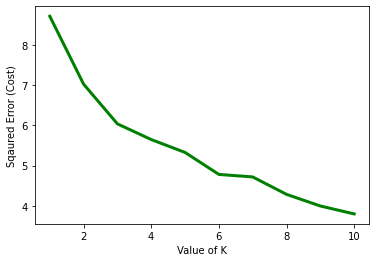

In [35]:
import matplotlib.pyplot as plt  
from matplotlib import style 

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(nola_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot

There isn't a clear elbow point in this graph, so we are going to use 7 becuase it looks alright.



In [36]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nola_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10]

array([2, 5, 2, 1, 2, 5, 2, 2, 2], dtype=int32)

Let's add the cluster labels into the dataset. Then, we can look at a new map.



In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nola_merge = nola_neigh

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
nola_merge = nola_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nola_merge.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,U.S. Naval Base,29.94608469,-90.02609253,1.0,Food,Pizza Place,Sandwich Place,Mexican Restaurant,Ethiopian Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant
1,Algiers Point,29.95246187,-90.0516057,1.0,Food,Wings Joint,New American Restaurant,Café,Sandwich Place,Seafood Restaurant,Pizza Place,Donut Shop,Cuban Restaurant,Deli / Bodega
2,Whitney,29.94720026,-90.04235744,1.0,Food,Sandwich Place,Wings Joint,American Restaurant,New American Restaurant,Seafood Restaurant,Pizza Place,Donut Shop,Cuban Restaurant,Deli / Bodega
3,Audubon,29.93299437,-90.12145042,2.0,Sandwich Place,Pizza Place,Diner,French Restaurant,Restaurant,Mexican Restaurant,Fast Food Restaurant,Sushi Restaurant,Café,Creperie
4,Old Aurora,29.92444011,-90,2.0,Pizza Place,American Restaurant,Sandwich Place,Food,Donut Shop,Ethiopian Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Eastern European Restaurant


Let's put this all on a map and take a look.



In [38]:
nola_merge['Cluster Labels'] = nola_merge['Cluster Labels'].fillna(0)
nola_merge['Cluster Labels'] = nola_merge['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[nola_lat, nola_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nola_merge['Latitude'], nola_merge['Longitude'], nola_merge['Neighborhood'], nola_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Step Four: Explore and Label the Clusters
Let's look at each cluster and determine what a good way to label them would be. This will help us better understand how restaraunts are distributed throughout the city.

Cluster 1

In [39]:
nola_merge.loc[nola_merge['Cluster Labels'] == 0, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
17,Lake Catherine,30.08810775,-89.76104736,0,NaN,NaN,NaN,NaN,NaN,NaN
18,Village De Lest,30.07325354,-89.90112305,0,NaN,NaN,NaN,NaN,NaN,NaN
19,Viavant - Venetian Isles,30.00311157,-89.945755,0,NaN,NaN,NaN,NaN,NaN,NaN
49,Filmore,30.01054422,-90.07707596,0,Chinese Restaurant,Sandwich Place,Bakery,Italian Restaurant,Pizza Place,Cafeteria


Cluster 1 appears to be a miscelanious cluster. Lots of 'Food' and 'NaN' categories here. Probablt not the best to open our restaraunt in these neighborhoods. We'll call it 'Worst Choice'.

Cluster 2




In [40]:
nola_merge.loc[nola_merge['Cluster Labels'] == 1, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,U.S. Naval Base,29.94608469,-90.02609253,1,Food,Pizza Place,Sandwich Place,Mexican Restaurant,Ethiopian Restaurant,Cuban Restaurant
1,Algiers Point,29.95246187,-90.0516057,1,Food,Wings Joint,New American Restaurant,Café,Sandwich Place,Seafood Restaurant
2,Whitney,29.94720026,-90.04235744,1,Food,Sandwich Place,Wings Joint,American Restaurant,New American Restaurant,Seafood Restaurant
7,Behrman,29.9348167,-90.02643585,1,Food,Breakfast Spot,Café,Seafood Restaurant,Falafel Restaurant,Deli / Bodega
23,Mcdonogh,29.94340726,-90.05141258,1,Food,Wings Joint,Restaurant,New American Restaurant,Café,Seafood Restaurant
41,St. Roch,29.98214852,-90.05209923,1,Food,Chinese Restaurant,Sandwich Place,Cajun / Creole Restaurant,Mexican Restaurant,Fast Food Restaurant
48,Lakeshore - Lake Vista,30.02325275,-90.09784698,1,Food Truck,Food,Wings Joint,Falafel Restaurant,Cuban Restaurant,Deli / Bodega
50,St. Bernard Area,29.99523236,-90.08016586,1,Food,Pizza Place,Fried Chicken Joint,Wings Joint,Falafel Restaurant,Deli / Bodega
57,Gentilly Terrace,30.00370621,-90.05235672,1,Food,Chinese Restaurant,Donut Shop,Southern / Soul Food Restaurant,Fast Food Restaurant,Fried Chicken Joint
58,Desire Area,29.99389432,-90.03330231,1,Food,Asian Restaurant,Seafood Restaurant,Wings Joint,Falafel Restaurant,Deli / Bodega


This cluster looks like it has a lot of Fast Food and Fast Casual restaurants. Depending on the neighborhood make-up, it could be a good choice for a more sit-down experience. We will call it 'Fast Casual Heavy'.

Cluster 3

In [41]:
nola_merge.loc[nola_merge['Cluster Labels'] == 2, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
3,Audubon,29.93299437,-90.12145042,2,Sandwich Place,Pizza Place,Diner,French Restaurant,Restaurant,Mexican Restaurant
4,Old Aurora,29.92444011,-90,2,Pizza Place,American Restaurant,Sandwich Place,Food,Donut Shop,Ethiopian Restaurant
6,Bayou St. John,29.97607064,-90.08651733,2,American Restaurant,Seafood Restaurant,Cajun / Creole Restaurant,Café,Breakfast Spot,Sandwich Place
8,Black Pearl,29.93589521,-90.13488293,2,Café,Sandwich Place,Italian Restaurant,Vietnamese Restaurant,Thai Restaurant,Deli / Bodega
10,Marlyville - Fontainebleau,29.95300103,-90.11346817,2,Pizza Place,Breakfast Spot,Fast Food Restaurant,Sandwich Place,Wings Joint,Diner
12,Mid-City,29.97040133,-90.09939194,2,Pizza Place,Sandwich Place,Mexican Restaurant,Cajun / Creole Restaurant,American Restaurant,Vietnamese Restaurant
13,St. Claude,29.97181404,-90.03926754,2,Chinese Restaurant,Deli / Bodega,Pizza Place,Restaurant,Bakery,Wings Joint
14,Central Business District,29.95002632,-90.07445812,2,Cajun / Creole Restaurant,Seafood Restaurant,Italian Restaurant,New American Restaurant,American Restaurant,Café
15,French Quarter,29.95883865,-90.06437302,2,Cajun / Creole Restaurant,Café,Seafood Restaurant,American Restaurant,Breakfast Spot,Italian Restaurant
16,Central City,29.93946537,-90.086689,2,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Café,Diner,Restaurant


This cluster seems to contain a lot of Cafes, 'Ethnic' Restaurants, and Seafood places. We will call it 'Neighborhood Restaurants' because those tend to fit those categories. It could be difficult to establish a new place with all these other options.

Cluster 4

In [42]:
nola_merge.loc[nola_merge['Cluster Labels'] == 3, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
20,New Aurora - English Turn,29.90732938,-89.94197845,3,Diner,Wings Joint,Gluten-free Restaurant,Cuban Restaurant,Deli / Bodega,Donut Shop


This cluster has a lot of'take out' foods. We will call this one 'Carryout'. This could be a good cluster to look at for a more sit-down experience.

Cluster 5

In [43]:
nola_merge.loc[nola_merge['Cluster Labels'] == 4, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
60,Florida Dev,29.98170245,-90.03252983,4,Wings Joint,Seafood Restaurant,Falafel Restaurant,Cuban Restaurant,Deli / Bodega,Diner


This neighborhood is in a cluster all alone. They have a diner and some wings. Unfortunately, English Turn is very far out, so it isn't going to be a good choice for us. We will label it as 'Bad Choice'.

Cluster 6

In [44]:
nola_merge.loc[nola_merge['Cluster Labels'] == 5, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
5,B. W. Cooper,29.95177397,-90.09175301,5,Fast Food Restaurant,Bakery,Food Truck,Pizza Place,Restaurant,Seafood Restaurant
9,Broadmoor,29.9465681,-90.10381222,5,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Bakery,Pizza Place,Chinese Restaurant
11,Gert Town,29.96028871,-90.10582924,5,Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Bakery,Chinese Restaurant,Japanese Restaurant
21,Tall Timbers - Brechtel,29.91030537,-90.01338959,5,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Bakery,Breakfast Spot,Deli / Bodega
51,Dillard,29.99865172,-90.06591797,5,Chinese Restaurant,Pizza Place,Donut Shop,Fast Food Restaurant,Southern / Soul Food Restaurant,Ethiopian Restaurant
52,St. Anthony,30.01515218,-90.06574631,5,Bakery,Pizza Place,Cajun / Creole Restaurant,Sushi Restaurant,Chinese Restaurant,Fried Chicken Joint
53,Lake Terrace & Oaks,30.02867753,-90.06420135,5,Fast Food Restaurant,Bakery,Chinese Restaurant,Cajun / Creole Restaurant,Sandwich Place,Italian Restaurant
54,Milneburg,30.01916539,-90.054245,5,Sandwich Place,Fast Food Restaurant,Italian Restaurant,Pizza Place,Chinese Restaurant,Bakery
56,Gentilly Woods,30.00994963,-90.03707886,5,Fast Food Restaurant,Fried Chicken Joint,Wings Joint,Breakfast Spot,Cajun / Creole Restaurant,Sandwich Place
67,Read Blvd East,30.03551382,-89.95519638,5,Fast Food Restaurant,Pizza Place,Comfort Food Restaurant,Cajun / Creole Restaurant,Sandwich Place,Bakery


It looks like this cluster has a good mix of options. It could be hard to find a market that stand out among all of the existing options in these neighborhoods. We will call this cluster 'Saturated'.

Cluster 7

In [45]:
nola_merge.loc[nola_merge['Cluster Labels'] == 6, nola_merge.columns[range(0,10)]]


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
45,City Park,29.99917205,-90.09372711,6,Pizza Place,Food,Taco Place,Wings Joint,Ethiopian Restaurant,Cuban Restaurant


Another cluster with only one neighborhood. It looks like there aren't many choices here, but there may not be much room for growth. We will call it 'Maybe' for now.

Let's add these labels to our mapping and see can get from it.

In [52]:
labels = ['Worst Choice','Fast Casual Heavy','Neighborhood Restaurants','Carryout','Bad Choice','Saturated','Maybe']

# create map
map_clusters2 = folium.Map(location=[nola_lat, nola_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nola_merge['Latitude'], nola_merge['Longitude'], nola_merge['Neighborhood'], nola_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7)
        Parse_html=True).add_to(map_clusters)
       
map_clusters2

IndentationError: unexpected indent (<ipython-input-52-03c016df5dc1>, line 24)

## Step Six: Build a Heat Map
Knowing what kind of restaraunts are prevelant in a neighborhood is only part of the equation. We need to be able to see how many restaurants are in each neighborhood. Let's try building a map where the larger the circle, the more restaurants we know of. First, we will need to have the count of restaurants in each neighborhood again.

In [53]:

nola_counts = nola_rests.groupby('Neighborhood').count()
nola_counts.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Algiers Point,9,9,9,9,9,9
Audubon,10,10,10,10,10,10
B. W. Cooper,13,13,13,13,13,13
Bayou St. John,40,40,40,40,40,40
Behrman,5,5,5,5,5,5



Let's use this to set the size of the bubbles on the map to be proportional to the number of restaurants we found, with a floor of 5 and increasing from there.

In [54]:
labels = ['Worst Choice','Fast Casual Heavy','Neighborhood Restaurants','Carryout','Bad Choice','Saturated','Maybe']

# create map
map_clusters = folium.Map(location=[nola_lat, nola_lng], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nola_merge['Latitude'], nola_merge['Longitude'], nola_merge['Neighborhood'], nola_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    try:
        size = int(nola_counts.loc[poi,'Venue'])
    except:
        size = 0
    folium.CircleMarker(
        [lat, lon],
        radius=5+size,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now THAT is a useful map of restaraunt locations in New Orleans! We can easily see where restaruants are densely located, and where they are not. We can more readily make decisions about where we would have the most and least competition, and we even have some idea of what the other types of restaraunts are. We can go a bit further in that regard, however.

## Step Seven: Making a Choice
Now that we've seen the heatmap, we can decide where a good spot for our new restaurant might be. Let's look more closely at the neighborhood of Gentitlly Terrace. We know from the map that it is Carryout heavy currently, but what does that mean for actual restaurants? We can find out!

Let's use the FourSquare API to search Gentilly Terrace and see what we can find out. First, we need to get the exact coordinates of that neighborhood.

In [55]:
neigh_id = nola_neigh[nola_neigh['Neighborhood']=='Gentilly Terrace'].index[0]

neighborhood_latitude = nola_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = nola_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

neighborhood_name = nola_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Gentilly Terrace are 30.00370621, -90.05235672.


Great. Now, let's run the search against the API and put the results into a dataframe.

In [56]:
radius = 1500
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,The Original Fiorellas',Italian Restaurant,30.012903,-90.050890
1,Zimmer's Seafood,Cajun / Creole Restaurant,30.008341,-90.064535
2,Good Time Sushi,Sushi Restaurant,30.012975,-90.059939
3,Daddy's Donuts,Donut Shop,30.000187,-90.061852
4,JuJu Bag Cafe,Café,30.013711,-90.050749
5,Chinese Tea Garden,Chinese Restaurant,30.012052,-90.060540
6,Pepperoni Ray's,Pizza Place,29.997244,-90.060167
7,McKenzie's Chicken In-A-Box,Southern / Soul Food Restaurant,29.997880,-90.060246
8,Rally's,Fast Food Restaurant,30.004734,-90.037007
9,Wingstop,Wings Joint,30.003569,-90.038999


This list seems to fit with our understanding of the neighborhood. Note that we expanded the radius compared to the city-wide search, and that is get a better understanding of the market around the neighborhood as well. We still see a lot of Fast Casual, Fast Food, and Carry-out, so we may be able to open a more sit down restaurant.

Let's try making a bar graph based on the count of each type of restaurant.

In [57]:
# Sort the data by frequency
sorted_venues = nearby_venues.groupby(['categories']).size().reset_index(name='Count')
sorted_venues.columns=['Restaurant Type','Count']
sorted_venues.set_index('Restaurant Type')

,Count
Restaurant Type,
Bakery,2
Café,2
Cajun / Creole Restaurant,2
Chinese Restaurant,2
Donut Shop,1
Fast Food Restaurant,4
Food,1
Fried Chicken Joint,1
Italian Restaurant,1


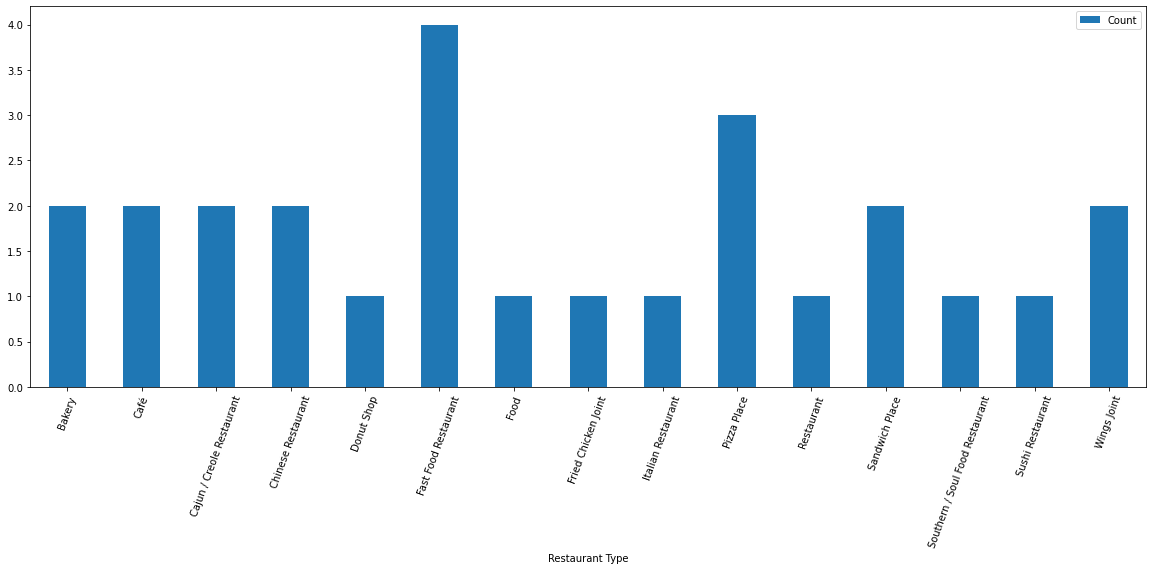

In [58]:
sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70)

plt.show()

As we can easily see, Fast Food is the most common restaurant type in Gentilly Terrace, followed by Pizza. What it appears to be lacking is a Mexican restaurant, so that may be a godo target for that neighborhood.

Let's wrap up our work by building a set of functions to easily call for a graph like this one for any neighborhood in the city.

In [59]:
def getCoords(neigh):
    try:
        neigh_id = nola_neigh[nola_neigh['Neighborhood']==neigh].index[0]

        neighborhood_latitude = nola_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
        neighborhood_longitude = nola_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

        neighborhood_name = nola_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name
        
        return [neighborhood_name,neighborhood_latitude,neighborhood_longitude]
    except:
        return print('Neighborhood name not recognized. Please try again.')

In [60]:
def getVenues(lat,lng,catId,radius=1500):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        catId, # add the category ID to the URL
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    return(nearby_venues)

In [61]:
def makeGraph():
    
    neigh = input('Neighborhood? ')
    
    coords = getCoords(neigh)
    
    df = getVenues(coords[1],coords[2],'4d4b7105d754a06374d81259')
    
    sorted_venues = df.groupby(['categories']).size().reset_index(name='Count')
    sorted_venues.columns=['Restaurant Type','Count']
    sorted_venues.set_index('Restaurant Type')
    
    sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70, title='Restaurants in {}'.format(neigh))

    return plt.show()

Methodolgy
To complete the analysis, there were several steps of data gathering, cleaning, and analysis. Data was pulled from Wikipedia and the FourSquare API, cleaned using the padas and BeautifulSoup libraries, and stored into pandas dataframes. Data was assembled to align latitude and longitude coordinates with neighborhood names in New Orleans, and that was mapped using the folium library.

The Foursquare API was used to find the (up to) 100 closest restaurants to each neighborhood center. That data was used to conduct k-means clustering, organizing the neighborhoods into 7 categories for consideration. These categories were 'Worst Choice', 'Fast Casual Heavy', 'Neighborhood Restaurants', 'Carryout', 'Bad Choice', 'Saturated', and 'Maybe'. Each of these categories represents either the confidence in the choice fo the neighborhood as a site for a new venture ('Bad Choice', 'Worst Choice', 'Maybe') or the predominate type of restaurant in a neighborhood. The 'elbow method' was used to determine the number of clusters used.

This was charted again using the folium library to show both the clustering/category for each neighborhood along with the density of restaraunts in teh form of a heat/bubble map.

The Foursquare API data was then used to develop a charting system to show the relative frequency of each type of restaurant in a given neighborhood.

Results
While there is no clear front runner for a possible new restaurant location, the data and visualization provides for easy exploration of that question. If it were up to me, I would locate the restaurant in the Dillard/Gentilly Terrace/Gentilly Woods areas, as those show little competition from 'sit down' restaurants, and much of the rest of the city is either densely packed with restaurants, or too remotely located from the population centers to be worth investment.

The charts below indicate that nicely.

Restaurant Density Map

In [62]:
map_clusters

Dillard Restaraunt Density



Neighborhood?  Dillard


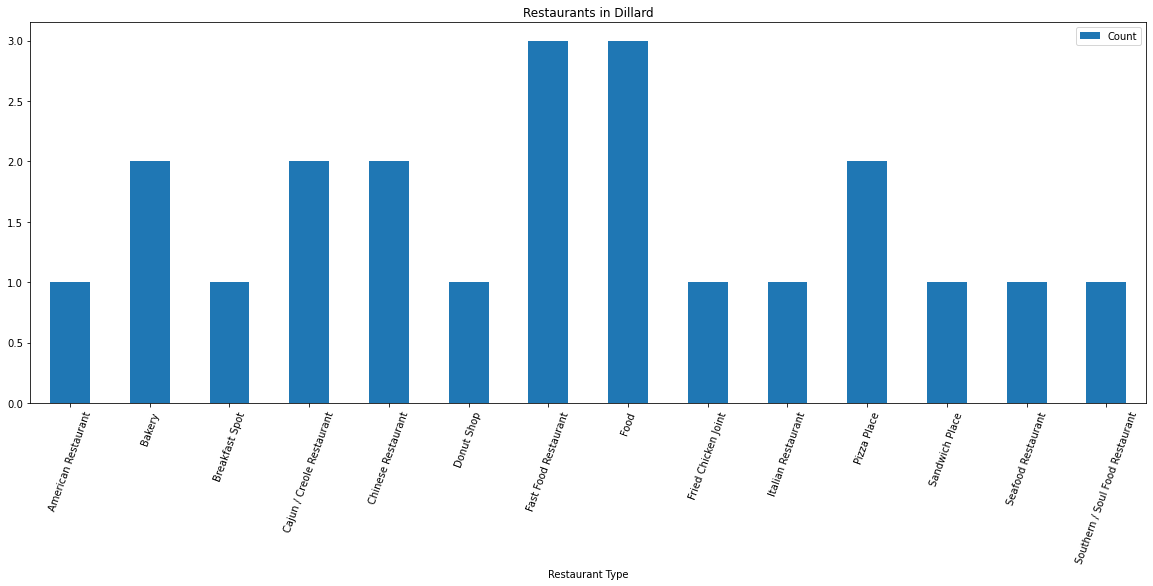

In [63]:
makeGraph()


Gentilly Terrace Restaurant Density



Neighborhood?  Gentilly Terrace


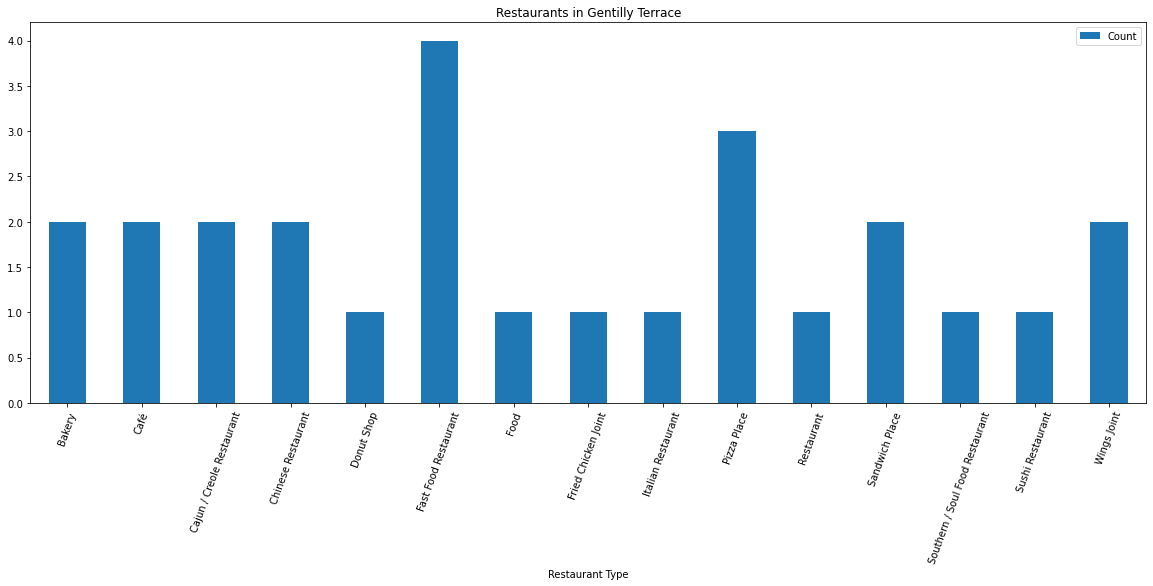

In [64]:
makeGraph()


Gentilly Woods Restaurant Density



Neighborhood?  Gentilly Woods


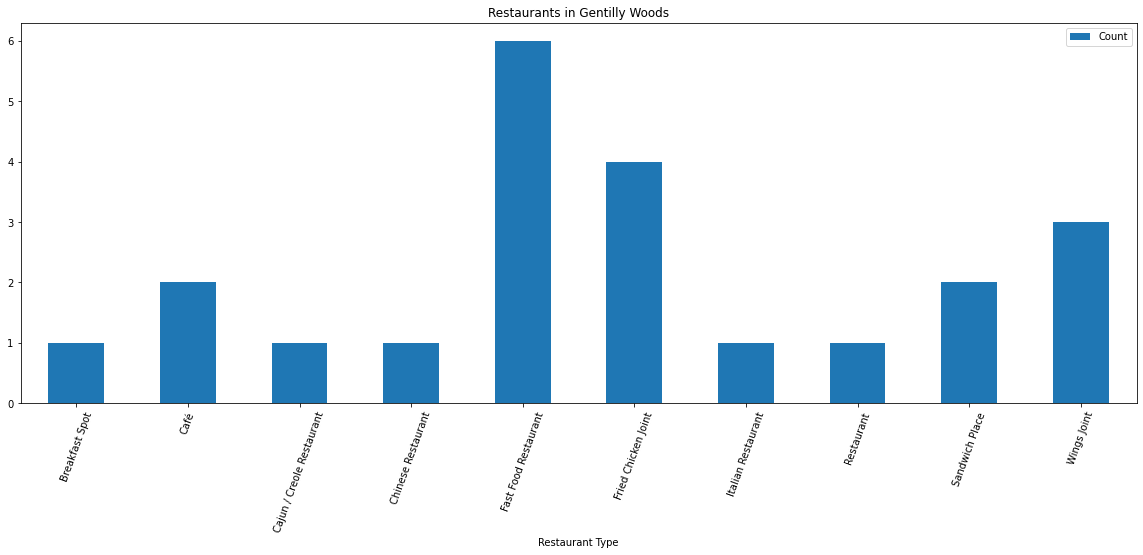

In [68]:
makeGraph()
























## Discussion


Much of this work is based on dynamic data sources, so it will need to be run again to get an accurate understanding of the current market. That being said, the author is confident that the work demonstrates an analysis of two key deciding factors for establishing a new business: market need and competition density. You want to land in a spot that allows you to thrive, but that doesn't cut you off from a customer base.

Expansion of the study could include exploring the values of commercial real estate in the neighborhoods as well as the general population of those areas. This would allow for a more robust decision making matrix for potential restaurateurs.

Another possible point of improvement is in the radius/maximum count for the use of the Foursquare API. The values chosen seemingly work well, but there is likely overlap in some of the neighborhoods. More fine tuning to the model would allow for a more accurate picture of each neighborhood. One could also explore the possibility of bounding the neighborhoods and filtering by restaurants that fall within the bounds.

## Conclusion


New Orleans remains a top destination for food tourists and chefs from around the world. The market is open to innovative ideas, and there are untapped local markets that are not far from the tourist destination centers. Not every new restaurant needs to be on river-front property in the French Quarter, and there are neighborhoods in need of more options. Exploring these needs can help a new restaurant beat the odds and become a local and tourist hotspot.